In [ ]:
%load_ext autoreload
%autoreload 2

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from helper_functions import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [102]:
## Setting Categorical and Numeric Features to be used in CatBoost algo
cat_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
               'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
               'Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond',
               'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical',
               'KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
               'PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition']
num_features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea',
               'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
               'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
               'Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
               '3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold','SalePrice'
               ]


In [103]:
# Re-creating the best dataset
train = pd.read_csv('train.csv',index_col=0)
test = pd.read_csv('test.csv',index_col=0)

train_df = basic_filling(train)
test_df = basic_filling(test)

train_df = mapped_values(train_df,train_df)
test_df = mapped_values(test_df,train_df)

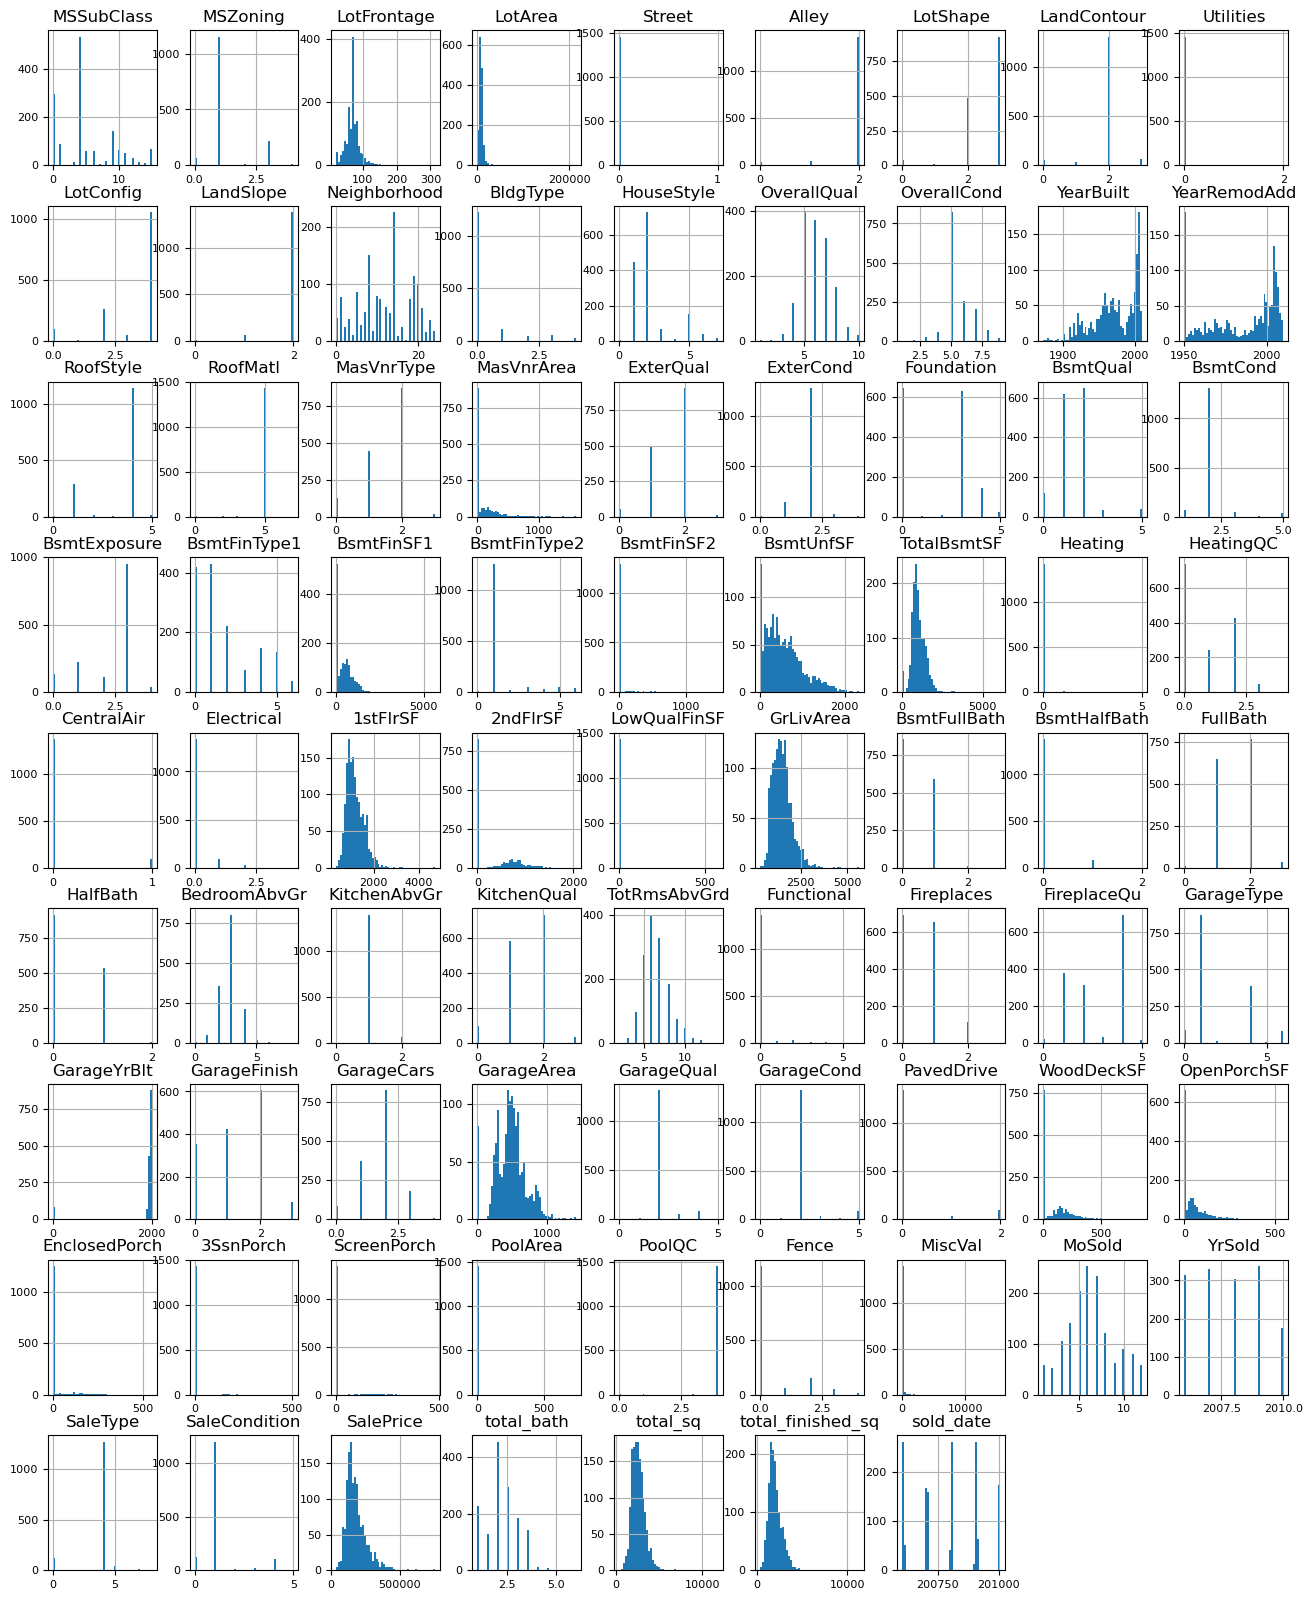

In [104]:
train_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

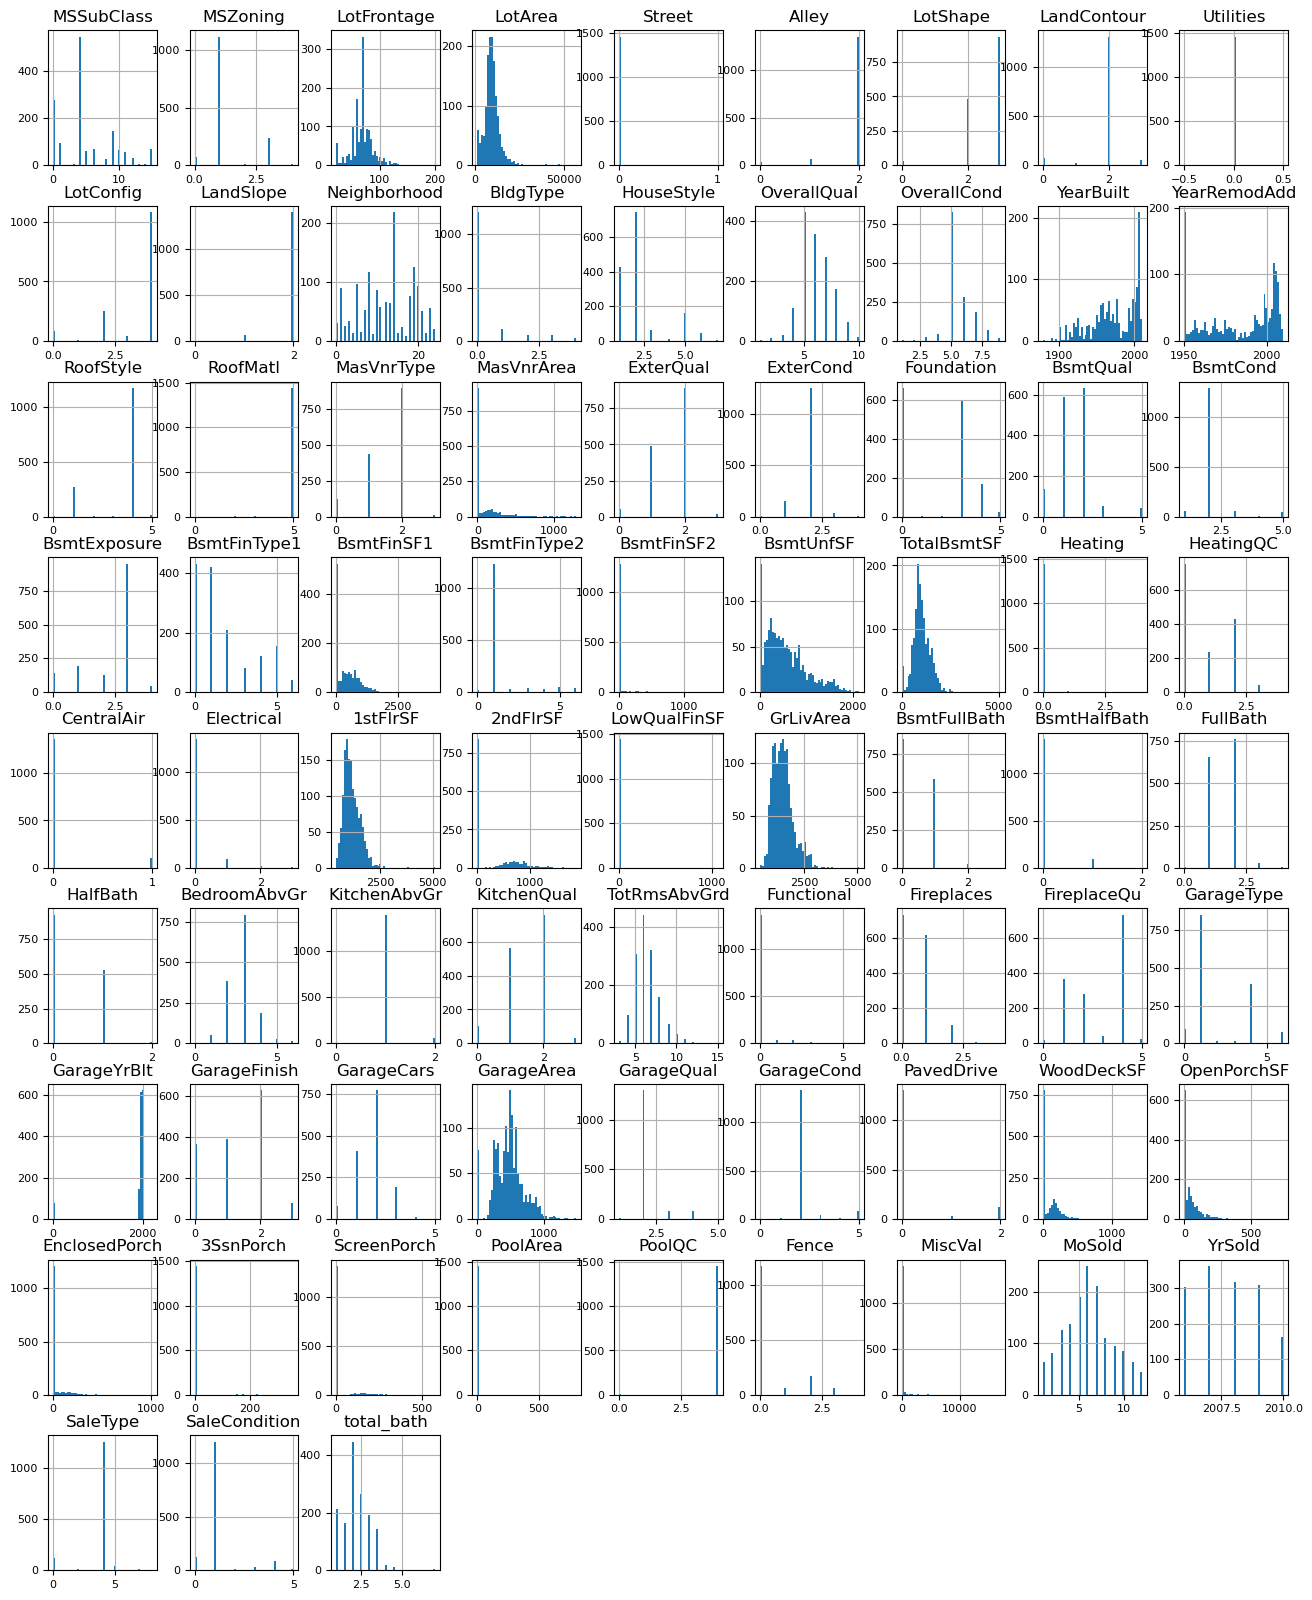

In [31]:
test_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [105]:
# # Splitting Train data into train and validate

# Setting my input and target data
X = train_df.drop('SalePrice',axis=1)
y = np.log1p(train_df.SalePrice) # Setting this to log10, since that is how scoring occurs

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=0)

X_test = test_df

In [106]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

X_test_scaled = scaler.fit_transform(X_test)

# Also scaling all data
X_scaled = scaler.fit_transform(X)

In [107]:
clf = xgb.XGBRegressor()

clf.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [108]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
# evaluate model
scores = cross_val_score(clf, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = abs(scores)
print('Mean Squared Error: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean Squared Error: 0.019 (0.005)


In [109]:
from sklearn.metrics import mean_squared_error

pred = clf.predict(X_val_scaled)

# print accuracy
print("RMSE: ", mean_squared_error(y_val, pred))

# Why is this so off from the actual scoring?

RMSE:  0.04512856213020738


In [110]:
# Re-training with full dataset
clf = xgb.XGBRegressor()

clf.fit(X_scaled, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [111]:
preds = clf.predict(X_test_scaled)

preds = np.expm1(preds)

pd.DataFrame(preds,test_df.index,columns=(['SalePrice'])).reset_index()\
                            .to_csv('XGB_submission.csv',index=False)

# XGB_submission.csv - Score: 0.18797

## Part 2: GridSearch

In [112]:
clf = xgb.XGBRegressor(seed=0,objective='reg:squarederror')


grid = {'n_estimators': [250,500,1000],
        'eta': [0.03,0.07, 0.1],
        'max_depth': [2,3,4]
       }

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=grid,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    cv = 5,
    verbose=2
)

grid_search.fit(X_scaled, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.03, 0.07, 0.1], 'max_depth': [2, 3, 4],
                         'n_estimators': [250, 500, 1000]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [71]:
grid_search.cv_results_

{'mean_fit_time': array([0.45317683, 0.90527525, 1.80564075, 0.6214222 , 1.27904763,
        2.62652254, 0.79692702, 1.69219365, 3.50970416, 0.47713695,
        0.9488482 , 1.89604902, 0.67559853, 1.36624751, 2.75432806,
        0.88220444, 1.79488034, 3.65262876, 0.48174076, 0.96713696,
        2.03668065, 0.89131694, 1.8026535 , 3.0367753 , 0.91457353,
        1.84331212, 3.6201026 ]),
 'std_fit_time': array([0.00163382, 0.00382163, 0.00273354, 0.00145541, 0.00249085,
        0.0097805 , 0.00701832, 0.00789206, 0.02096439, 0.00770346,
        0.00323362, 0.00759033, 0.00322914, 0.0041269 , 0.00905184,
        0.00584973, 0.00842943, 0.01397539, 0.00175325, 0.00825477,
        0.1367047 , 0.14194386, 0.14464367, 0.09053383, 0.00381419,
        0.00928176, 0.09833451]),
 'mean_score_time': array([0.00200367, 0.00226722, 0.00290623, 0.0020339 , 0.00249658,
        0.00360274, 0.00223804, 0.00308757, 0.00466728, 0.00189919,
        0.0023592 , 0.00296082, 0.00211887, 0.00266056, 0.003671

In [113]:
grid_search.best_params_, grid_search.best_score_

({'eta': 0.03, 'max_depth': 4, 'n_estimators': 500}, -0.1226505034570633)

In [114]:
preds = grid_search.predict(X_test_scaled)

preds = np.expm1(preds)

pd.DataFrame(preds,test_df.index,columns=(['SalePrice'])).reset_index()\
                            .to_csv('XGB_submission_gs.csv',index=False)

# XGB_submission_gs.csv - Score: 0.13437

In [74]:
preds

array([126697.33, 160031.83, 191198.33, ..., 175237.16, 125213.96,
       218334.05], dtype=float32)

In [115]:
cb_preds = pd.read_csv('catboost_submission_log_target_gs_depth_opt_6000.csv', sep=',',index_col=0)

In [116]:
avg_preds = (cb_preds.SalePrice+preds)/2

avg_preds

Id
1461    119451.004870
1462    159547.545413
1463    186117.096234
1464    200255.031655
1465    193829.856811
            ...      
2915     79901.028841
2916     81787.148093
2917    155918.929757
2918    115360.077552
2919    212958.136436
Name: SalePrice, Length: 1459, dtype: float64

In [117]:
pd.DataFrame(avg_preds,test_df.index,columns=(['SalePrice'])).reset_index()\
                            .to_csv('XGB_submission_avg_preds.csv',index=False)

# XGB_submission_avg_preds.csv - Score: 0.12279

[CV] END ............eta=0.03, max_depth=2, n_estimators=250; total time=   0.5s
[CV] END ............eta=0.03, max_depth=2, n_estimators=500; total time=   1.0s
[CV] END ...........eta=0.03, max_depth=2, n_estimators=1000; total time=   1.9s
[CV] END ...........eta=0.03, max_depth=2, n_estimators=1000; total time=   1.9s
[CV] END ............eta=0.03, max_depth=3, n_estimators=500; total time=   1.4s
[CV] END ...........eta=0.03, max_depth=3, n_estimators=1000; total time=   2.9s
[CV] END ............eta=0.03, max_depth=4, n_estimators=250; total time=   0.9s
[CV] END ............eta=0.03, max_depth=4, n_estimators=250; total time=   0.9s
[CV] END ............eta=0.03, max_depth=4, n_estimators=500; total time=   1.8s
[CV] END ...........eta=0.03, max_depth=4, n_estimators=1000; total time=   3.8s
[CV] END ............eta=0.07, max_depth=2, n_estimators=250; total time=   0.5s
[CV] END ............eta=0.07, max_depth=2, n_estimators=250; total time=   0.5s
[CV] END ............eta=0.0